## Classification and Regression Trees

We are ready to finally begin modeling our data, in the Modeling Phase. Data science offers a wide variety of methods and algorithms for modeling large data sets. We begin here with one of the simplest methods: decision trees. In this chapter we will work with the adult_ch6_training and the adult_ch6_test data sets. These are adapted from the Adult data set from the UCI repository. For simplicity, only two predictors and the target are retained, as follows:

- Marital status, a categorical predictor with classes married, divorced, never‐married, separated, and widowed.
- Cap_gains_losses, a numerical predictor, equal to capital gains + |capital losses|.
- Income, a categorical target variable with two classes, >50k and ≤50k, representing individuals whose income is greater than 50,000 per year, and those with income less than or equal to 50,000 per year.

A decision tree consists of a set of decision nodes, connected by branches, extending downward from the root node until terminating in leaf nodes. Beginning at the root node, which by convention is placed at the top of the decision tree diagram, variables are tested at the decision nodes, with each possible outcome resulting in a branch. Each branch then leads either to another decision node or to a terminating leaf node.

In [1]:
# dependencies
import pandas as pd
import numpy as np
import statsmodels.tools.tools as stattools
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [2]:
# load data
url = 'https://raw.githubusercontent.com/ArashVafa/DESC624/master/adult_ch6_training'
adult_tr = pd.read_csv(url)
adult_tr.head()
data = adult_tr
data.head()

,Marital status,Income,Cap_Gains_Losses
0,Never-married,<=50K,0.02174
1,Divorced,<=50K,0.00000
2,Married,<=50K,0.00000
3,Married,<=50K,0.00000
4,Married,<=50K,0.00000


### Data Processing

In [3]:
# segment
y = adult_tr[['Income']]

y.head()

We have a categorical variable, Marital status, among our predictors. The CART model implemented in the sklearn package needs categorical variables converted to a dummy variable form. 

Thus, we will make a series of dummy variables for Marital status using the categorical() command.

In [4]:
# identify the categorical variables which need to be converted
mar_np = np.array(adult_tr['Marital status'])
(mar_cat, mar_cat_dict) = stattools.categorical(mar_np, dictnames = True)#, drop = True)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tools/tools.py:158: FutureWarning: categorical is deprecated. Use pandas Categorical to represent categorical data and can get_dummies to construct dummy arrays. It will be removed after release 0.13.
  warnings.warn(


In [5]:
# view the result
mar_cat

array([['Never-married', 0.0, 0.0, 1.0, 0.0, 0.0],
       ['Divorced', 1.0, 0.0, 0.0, 0.0, 0.0],
       ['Married', 0.0, 1.0, 0.0, 0.0, 0.0],
       ...,
       ['Married', 0.0, 1.0, 0.0, 0.0, 0.0],
       ['Divorced', 1.0, 0.0, 0.0, 0.0, 0.0],
       ['Married', 0.0, 1.0, 0.0, 0.0, 0.0]], dtype=object)

We turn the variable Marital status into an array using array(), then use the categorical() command from the stattools package to create a matrix of dummy variables for each value of Marital status. We save the matrix and dictionary separately using (mar_cat, mar_cat_dict).

The matrix mar_cat contains five columns, one for each category in the original Marital status variable. Each row represents a record in the adult_tr data set. Each row will have a 1 in the column which matches the value that record had in the original Marital status variable. You can tell which column represents which category by examining mar_cat_dict. In our case, the first row of mar_cat has a 1 in the third column. By examining mar_cat_dict, we know the third column represents the “Never married” category. Sure enough, the first record of adult_tr has “Never married” as the Marital status variable value.

Now, we need to add the newly made dummy variables back into the X variables.

In [6]:
mar_cat_pd = pd.DataFrame(mar_cat)
X = pd.concat((adult_tr[['Cap_Gains_Losses']], mar_cat_pd), axis = 1)

In [7]:
mar_cat_pd.columns = ['MS', "1", "2", "3", "4", "5"]

In [8]:
mar_cat_pd

,MS,1,2,3,4,5
0,Never-married,0.0,0.0,1.0,0.0,0.0
1,Divorced,1.0,0.0,0.0,0.0,0.0
2,Married,0.0,1.0,0.0,0.0,0.0
3,Married,0.0,1.0,0.0,0.0,0.0
4,Married,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
18756,Divorced,1.0,0.0,0.0,0.0,0.0
18757,Married,0.0,1.0,0.0,0.0,0.0
18758,Married,0.0,1.0,0.0,0.0,0.0
18759,Divorced,1.0,0.0,0.0,0.0,0.0


In [9]:
X.head()

,Cap_Gains_Losses,0,1,2,3,4,5
0,0.02174,Never-married,0.0,0.0,1.0,0.0,0.0
1,0.00000,Divorced,1.0,0.0,0.0,0.0,0.0
2,0.00000,Married,0.0,1.0,0.0,0.0,0.0
3,0.00000,Married,0.0,1.0,0.0,0.0,0.0
4,0.00000,Married,0.0,1.0,0.0,0.0,0.0


We first make the mar_cat matrix a data frame using the DataFrame() command. We then use the concat() command to attach the predictor variable Cap_Gains_Losses to the data frame of dummy variables that represent marital status. We save the result as X.

Before we run the CART algorithm, note that the columns of X do not include the different values of the Marital status variable. Run mar_cat_dict to see that the first column is for the value “Divorced,” the second for “Married,” and so on. Since the first column of X is Cap_Gains_Losses, we can specify the names of each column of X.

In [10]:
X_names = ["Cap_Gains_Losses", "Divorced", "Married", "Never-married", "Separated", "Widowed"]

In [11]:
X.head()

,Cap_Gains_Losses,0,1,2,3,4,5
0,0.02174,Never-married,0.0,0.0,1.0,0.0,0.0
1,0.00000,Divorced,1.0,0.0,0.0,0.0,0.0
2,0.00000,Married,0.0,1.0,0.0,0.0,0.0
3,0.00000,Married,0.0,1.0,0.0,0.0,0.0
4,0.00000,Married,0.0,1.0,0.0,0.0,0.0


It will help us when visualizing the CART model to know the levels of y as well.

In [12]:
y_names = ["<=50K", ">50K"]

In [13]:
y.head()

,Income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K


In [14]:
X2 = pd.concat((adult_tr[['Cap_Gains_Losses']], mar_cat_pd), axis = 1)

In [15]:
X2.head()

,Cap_Gains_Losses,MS,1,2,3,4,5
0,0.02174,Never-married,0.0,0.0,1.0,0.0,0.0
1,0.00000,Divorced,1.0,0.0,0.0,0.0,0.0
2,0.00000,Married,0.0,1.0,0.0,0.0,0.0
3,0.00000,Married,0.0,1.0,0.0,0.0,0.0
4,0.00000,Married,0.0,1.0,0.0,0.0,0.0


In [16]:
X2 = X2.drop(columns = ['MS'])

In [17]:
dt = DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes=5)
dt.fit(X2, y)

DecisionTreeClassifier(max_leaf_nodes=5)

In [18]:
from six import StringIO
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from IPython.display import Image 
from pydot import graph_from_dot_data
import pandas as pd
import numpy as np

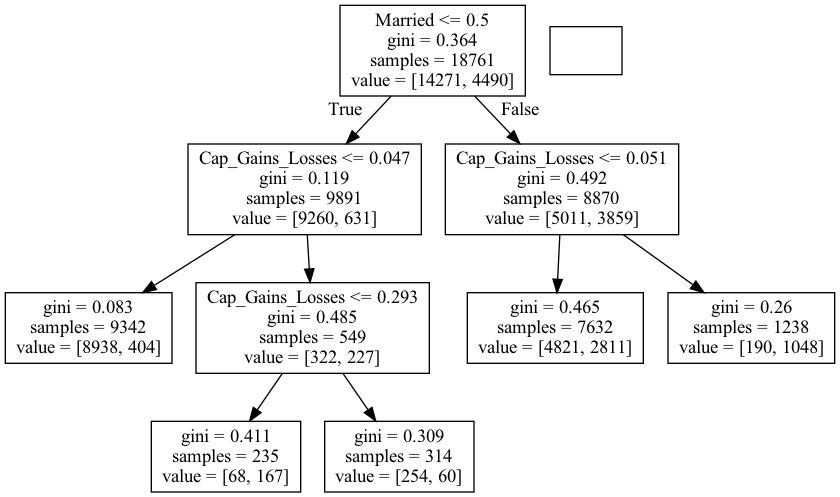

In [19]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, feature_names=X_names)
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [20]:
cart01 = DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes=5).fit(X2,y)

To run the CART algorithm, we use the DecisionTreeClassifier() command. The DecisionTreeClassifier() command sets up the various parameters for the decision tree. For example, the criterion = “gini” input specifies that we are using a CART model which utilizes the Gini criterion, and the max_leaf_nodes input trims the CART tree to have at most the specified number of leaf nodes. For this example, we have limited our tree to five leaf nodes.

The fit() command tells Python to fit the decision tree that was previously specified to the data. The predictor variables are given first, followed by the target variable. Thus, the two inputs to fit() are the X and y objects we created. We save the decision tree as cart01.

Finally, to obtain the tree structure, we use the export_graphviz() command.

In [22]:
export_graphviz(cart01, out_file = "test.dot", feature_names=X_names, class_names=y_names)

In [23]:
predIncomeCART = cart01.predict(X2)